In [1]:
from matplotlib import font_manager
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

font_path = '/System/Library/Fonts/Hiragino Sans GB.ttc'
my_font = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

# 读取数据
data = pd.read_csv('data/材料1.csv')

In [2]:
data = data[data['励磁波形'] == '正弦波']
print(data.shape)

(1067, 1028)


In [3]:
freq = data['频率，Hz']
loss = data['磁芯损耗，w/m3']

Bm_values = data.iloc[:, 4:].max(axis=1).values

In [4]:
def predict_loss(f, Bm, k1, alpha1, beta1):
    return k1 * (f ** alpha1) * (Bm ** beta1)

In [5]:
initial_guess = [1e-5, 1.5, 2.5]
# 用 curve_fit 来拟合参数，xdata 是足足一个二维数组。取出我们的 frequency 和 B_max 合并
popt, pcov = curve_fit(
    lambda xdata, k1, alpha1, beta1: predict_loss(xdata[0], xdata[1], k1, alpha1, beta1),
    (freq, Bm_values),  # 这里将 frequency 和 B_max 合并为 xdata
    loss, p0=initial_guess
)
k1, alpha1, beta1 = popt
print(f'拟合结果：k1={k1}, alpha1={alpha1}, beta1={beta1}')

拟合结果：k1=1.4997417251154614, alpha1=1.4296345737356402, beta1=2.4712537948884052


/var/folders/gy/6wf0tc3n7276h9vd9dqcpkvw0000gn/T/ipykernel_22077/3652110823.py:2: RuntimeWarning: overflow encountered in power
  return k1 * (f ** alpha1) * (Bm ** beta1)


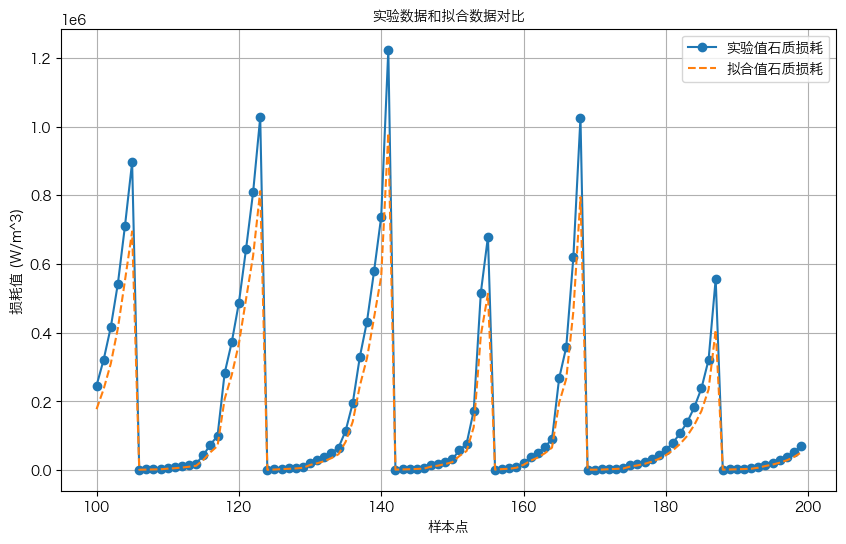

In [6]:
import matplotlib.font_manager as fm

# 设置字体和符号
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 使用拟合函数得到预测值和原始数据
P_pred_steinmetz = predict_loss(freq, Bm_values, k1, alpha1, beta1)

# 绘制实验数据和预测数据对比
plt.figure(figsize=(10, 6))
plt.plot(loss[100:200], label='实验值实际损耗', marker='o')
plt.plot(P_pred_steinmetz[100:200], label='拟合值实际损耗', linestyle='--')
plt.xlabel('样本点', fontproperties=my_font)
plt.ylabel('损耗值 (W/m^3)', fontproperties=my_font)
plt.legend(prop=my_font)
plt.title('实验数据和拟合数据对比', fontproperties=my_font)
plt.grid(True)
plt.show()


In [7]:
residuals = loss - P_pred_steinmetz

mse = np.mean(residuals ** 2)
print(f'MSE: {mse}')
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
mae = np.mean(np.abs(residuals))
print(f'MAE: {mae}')
mape = np.mean(np.abs(residuals) / loss)
print(f'MAPE: {mape}')

MSE: 1638190471.6410015
RMSE: 40474.56573752214
MAE: 20615.53499775187
MAPE: 0.35662630741301077


In [8]:
temp = data['温度，oC']


def predict_loss2(T, f, Bm, k1, alpha1, beta1, a, b):
    gamma_T = 1 + a * (T - 25) + b * (T - 25) ** 2
    return k1 * (f ** alpha1) * (Bm ** beta1) * gamma_T


def predict_loss1(T, f, Bm, k1, alpha1, beta1, a):
    gamma_T = 1 + a * (T - 25)
    return k1 * (f ** alpha1) * (Bm ** beta1) * gamma_T

In [9]:
initial_guess = [1e-5, 1.5, 2.5, 1e-3, 1e-5]
popt2, pcov2 = curve_fit(
    lambda inputs, k1, alpha1, beta1, a, b: predict_loss2(inputs[0], inputs[1], inputs[2], k1, alpha1, beta1, a, b),
    (temp, freq, Bm_values), loss, p0=initial_guess)
popt1, pcov1 = curve_fit(
    lambda inputs, k1, alpha1, beta1, a: predict_loss1(inputs[0], inputs[1], inputs[2], k1, alpha1, beta1, a),
    (temp, freq, Bm_values), loss, p0=initial_guess[:-1])

k1_opt, alpha1_opt, beta1_opt, a_opt = popt1
k2_opt, alpha2_opt, beta2_opt, a2_opt, b2_opt = popt2
print(f"一次拟合后的参数: k1 = {k1_opt}, alpha1 = {alpha1_opt}, beta1 = {beta1_opt}, a = {a_opt}")
print(f"二次拟合后的参数: k1 = {k2_opt}, alpha1 = {alpha2_opt}, beta1 = {beta2_opt}, a = {a2_opt}, b = {b2_opt}")



一次拟合后的参数: k1 = 1.6177786470303621, alpha1 = 1.4385472184091812, beta1 = 2.432449849286036, a = -0.006265132728962558
二次拟合后的参数: k1 = 1.2590296305087285, alpha1 = 1.4667402586530278, beta1 = 2.4509236582023313, a = -0.012168085171642508, b = 9.50493212188775e-05


/var/folders/gy/6wf0tc3n7276h9vd9dqcpkvw0000gn/T/ipykernel_22077/171223983.py:6: RuntimeWarning: overflow encountered in power
  return k1 * (f ** alpha1) * (Bm ** beta1) * gamma_T
/var/folders/gy/6wf0tc3n7276h9vd9dqcpkvw0000gn/T/ipykernel_22077/171223983.py:11: RuntimeWarning: overflow encountered in power
  return k1 * (f ** alpha1) * (Bm ** beta1) * gamma_T


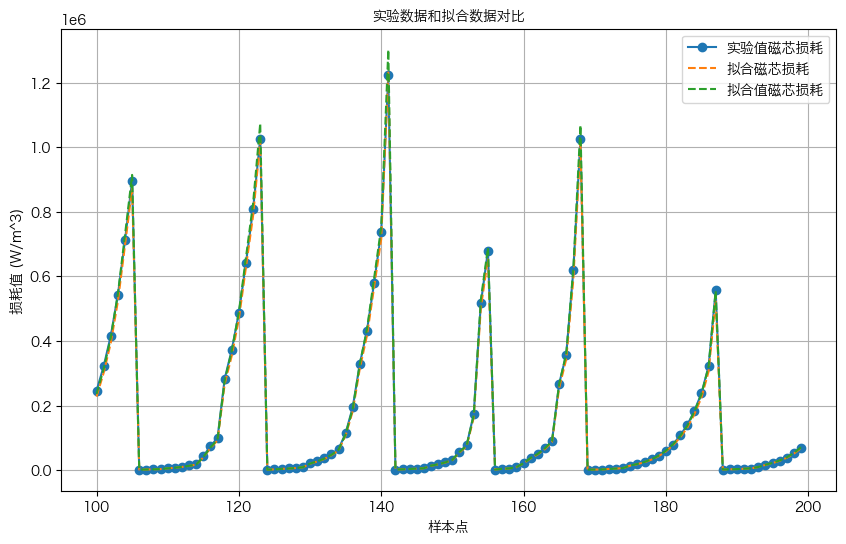

In [10]:

# 使用拟合函数得到预测值和原始数据
P_pred_new1 = predict_loss1(temp, freq, Bm_values, k1_opt, alpha1_opt, beta1_opt, a_opt)
P_pred_new2 = predict_loss2(temp, freq, Bm_values, k2_opt, alpha2_opt, beta2_opt, a2_opt, b2_opt)

# 绘制实验数据和预测数据对比
plt.figure(figsize=(10, 6))
plt.plot(loss[100:200], label='实验值磁芯损耗', marker='o')
plt.plot(P_pred_new1[100:200], label='拟合磁芯损耗', linestyle='--')
plt.plot(P_pred_new2[100:200], label='拟合值磁芯损耗', linestyle='--')
plt.xlabel('样本点', fontproperties=my_font)
plt.ylabel('损耗值 (W/m^3)', fontproperties=my_font)
plt.legend(prop=my_font)
plt.title('实验数据和拟合数据对比', fontproperties=my_font)
plt.grid(True)
plt.show()

In [11]:
residuals = loss - P_pred_new1

mse = np.mean(residuals ** 2)
print(f'MSE: {mse}')
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
mae = np.mean(np.abs(residuals))
print(f'MAE: {mae}')
mape = np.mean(np.abs(residuals) / loss)
print(f'MAPE: {mape}')

MSE: 273567131.06360286
RMSE: 16539.864904635797
MAE: 9717.076784506167
MAPE: 0.2562670423928896


In [12]:
residuals = loss - P_pred_new2

mse = np.mean(residuals ** 2)
print(f'MSE: {mse}')
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
mae = np.mean(np.abs(residuals))
print(f'MAE: {mae}')
mape = np.mean(np.abs(residuals) / loss)
print(f'MAPE: {mape}')

MSE: 134806625.10502732
RMSE: 11610.625526001057
MAE: 6775.1848816021575
MAPE: 0.22185397145624708
